In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sandeepkrmahto","key":"dbee347ebe46a022e0aaa9c493e581e9"}'}

In [ ]:
import os
import shutil

# Create the .kaggle directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the kaggle.json file to the .kaggle directory
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set the appropriate permissions
os.chmod("/root/.kaggle/kaggle.json", 0o600)


In [ ]:
!pip install kaggle
!kaggle datasets download -d missan/miniucfcrime


Dataset URL: https://www.kaggle.com/datasets/missan/miniucfcrime
License(s): unknown


In [ ]:
import zipfile

with zipfile.ZipFile("miniucfcrime.zip", 'r') as zip_ref:
    zip_ref.extractall("mini_ucf_crime")


In [ ]:
import os

data_path = "mini_ucf_crime"
categories = os.listdir(data_path)
print("Available categories:", categories)


Available categories: ['crimeucfdataset']


## Explore Videos Inside the Dataset

In [ ]:
data_path = "mini_ucf_crime/crimeucfdataset"
categories = os.listdir(data_path)
print("Available categories:", categories)


Available categories: ['Anomaly-Videos-Part-1', 'Normal-Videos-Part-1']


In [ ]:
for category in categories:
    category_path = os.path.join(data_path, category)
    files = os.listdir(category_path)
    print(f"{category}: {len(files)} videos")


Anomaly-Videos-Part-1: 14 videos
Normal-Videos-Part-1: 19 videos


Sample video path: mini_ucf_crime/crimeucfdataset/Anomaly-Videos-Part-1/Explosion003_x264.mp4


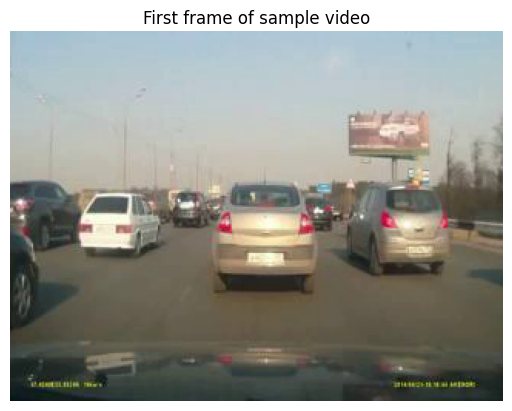

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Pick a sample video
sample_video_path = os.path.join(data_path, categories[0], os.listdir(os.path.join(data_path, categories[0]))[0])
print("Sample video path:", sample_video_path)

# Load the video
cap = cv2.VideoCapture(sample_video_path)
success, frame = cap.read()

if success:
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title("First frame of sample video")
    plt.axis("off")
    plt.show()
else:
    print("Could not read video")


## Extract Frames from Videos

In [ ]:
import cv2
import os
from tqdm import tqdm

def extract_frames_from_videos(video_dir, output_dir, label, frame_interval=30):
    os.makedirs(output_dir, exist_ok=True)
    count = 0

    for video_name in tqdm(os.listdir(video_dir), desc=f"Processing {label}"):
        video_path = os.path.join(video_dir, video_name)
        cap = cv2.VideoCapture(video_path)
        frame_num = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_num % frame_interval == 0:
                frame_path = os.path.join(output_dir, f"{label}_frame_{count}.jpg")
                resized_frame = cv2.resize(frame, (128, 128))
                cv2.imwrite(frame_path, resized_frame)
                count += 1
            frame_num += 1
        cap.release()


In [ ]:
# Define input and output paths
anomaly_videos_path = "mini_ucf_crime/crimeucfdataset/Anomaly-Videos-Part-1"
normal_videos_path = "mini_ucf_crime/crimeucfdataset/Normal-Videos-Part-1"

anomaly_frames_path = "frames_dataset/Anomaly"
normal_frames_path = "frames_dataset/Normal"

# Extract frames (every 30th frame)
extract_frames_from_videos(anomaly_videos_path, anomaly_frames_path, "anomaly")
extract_frames_from_videos(normal_videos_path, normal_frames_path, "normal")


Processing normal: 100%|██████████| 19/19 [00:23<00:00,  1.22s/it]


## Prepare Dataset for Training

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    "frames_dataset",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    "frames_dataset",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 2337 images belonging to 2 classes.
Found 583 images belonging to 2 classes.


## Build a CNN for Classification

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6480 - loss: 0.6399 - val_accuracy: 0.7496 - val_loss: 0.6125
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.9802 - loss: 0.0829 - val_accuracy: 0.8199 - val_loss: 0.3048
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9952 - loss: 0.0148 - val_accuracy: 0.8302 - val_loss: 0.3609
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9984 - loss: 0.0055 - val_accuracy: 0.8045 - val_loss: 0.4592
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9981 - loss: 0.0058 - val_accuracy: 0.7667 - val_loss: 0.8984
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 1.0000 - loss: 9.8073e-04 - val_accuracy: 0.7684 - val_loss: 1.1737
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 1.0000 - loss: 1.1875e-04 - val_accuracy: 0.7684 - val_loss: 1.4182
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 1.0000 - loss: 5.9339e-04 - val_accuracy: 0.7684 - val_lo

## Evaluate the Model

In [ ]:
loss, acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {acc * 100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.8366 - loss: 0.5259
Validation Accuracy: 83.53%


## Plot Confusion Matrix & Classification Report

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 546ms/step

Classification Report:

              precision    recall  f1-score   support

      Normal       0.54      0.40      0.46       316
     Anomaly       0.46      0.60      0.52       267

    accuracy                           0.49       583
   macro avg       0.50      0.50      0.49       583
weighted avg       0.50      0.49      0.49       583



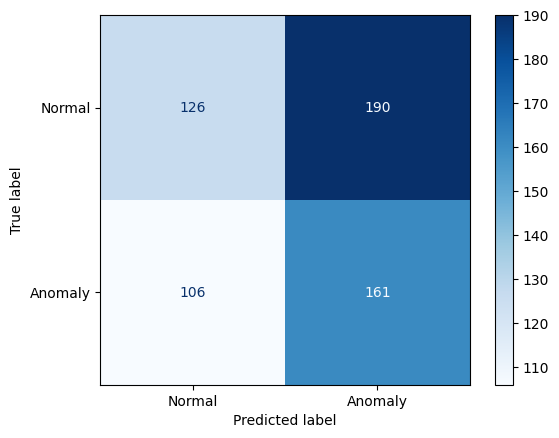

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions and true labels
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = (preds > 0.5).astype(int).ravel()
y_true = val_generator.classes

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="Blues")


In [ ]:
print(train_generator.class_indices)


{'Anomaly': 0, 'Normal': 1}


In [ ]:
def predict_video(video_path, model, frame_interval=30):
    cap = cv2.VideoCapture(video_path)
    frame_num = 0
    predictions = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_num % frame_interval == 0:
            frame_resized = cv2.resize(frame, (128, 128))
            frame_normalized = frame_resized / 255.0
            frame_input = np.expand_dims(frame_normalized, axis=0)
            pred = model.predict(frame_input)[0][0]
            predictions.append(pred)
        frame_num += 1
    cap.release()

    avg_score = np.mean(predictions)
    label = "Anomaly Detected" if avg_score < 0.5 else "Normal Behavior"
    print(f"Prediction Score: {avg_score:.2f} - {label}")


In [ ]:
predict_video("/content/mini_ucf_crime/crimeucfdataset/Anomaly-Videos-Part-1/Fighting009_x264.mp4", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━

In [ ]:
!pip install gradio --quiet
import gradio as gr

def classify_video(video_file):
    cap = cv2.VideoCapture(video_file)
    predictions = []
    frame_num = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_num % 30 == 0:
            resized = cv2.resize(frame, (128, 128))
            normalized = resized / 255.0
            input_data = np.expand_dims(normalized, axis=0)
            pred = model.predict(input_data)[0][0]
            predictions.append(pred)
        frame_num += 1
    cap.release()

    avg_score = np.mean(predictions)
    return "🚨 Anomaly Detected" if avg_score < 0.5 else "✅ Normal Behavior"

gr.Interface(fn=classify_video, inputs=gr.Video(), outputs="text", title="Crime Detection from Video").launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://23d4232d5376566ecd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
